In [2]:
import random
import numpy as np
import pandas as pd
from faker import Faker

# Set the seed globally at the highest level
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
Faker.seed(SEED)

from src.data_generator.visitor import generate_visitors, visitor_arrival_times, gaussian_arrivals
from src.data_generator.website import Website
from src.data_generator.simulation import run_simulation
import simpy

ImportError: cannot import name 'run_simulation' from 'src.data_generator.simulation' (/Users/spencerwood/Documents/Personal Projects/website-simulation/src/data_generator/simulation.py)

In [39]:
import sqlite3
DB_PATH = 'website_data.db'
conn = sqlite3.connect(DB_PATH)

cursor = conn.cursor()
# Execute SQL command to drop the table
cursor.execute("DROP TABLE IF EXISTS visitors")
cursor.execute("DROP TABLE IF EXISTS interactions")
# Commit the change and close the connection
conn.commit()
conn.close()

In [ ]:
query = '''
Select *
FROM visitors
'''

demo_data = pd.read_sql(query, conn)
demo_data

In [136]:
import sqlite3
DB_PATH = 'website_data.db'
conn = sqlite3.connect(DB_PATH)

query = '''
Select *
FROM interactions
'''

interactions_df = pd.read_sql(query, conn)

<Axes: xlabel='timestamp'>

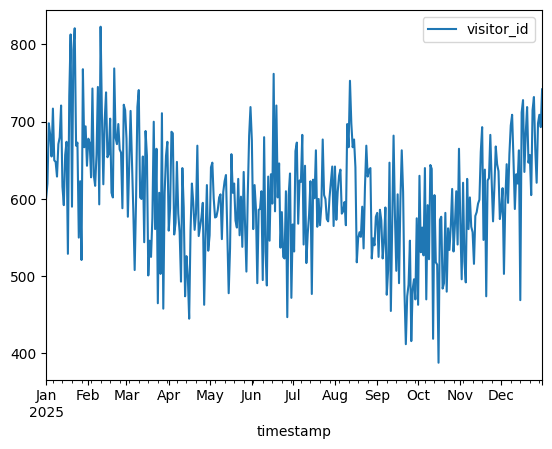

In [137]:
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])
daily_traffic = interactions_df[['timestamp','visitor_id']].groupby(pd.Grouper(key='timestamp',freq='D')).nunique()
daily_traffic.plot()

<Axes: xlabel='timestamp'>

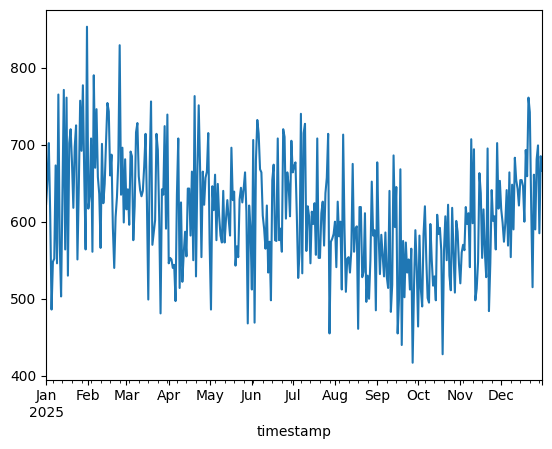

In [ ]:
def seasonal_multiplier(date, gamma_1, gamma_2, harmonics=2):
    """Computes seasonal adjustment using a Fourier series approximation.

    Parameters:
    t (int or array): Time index (e.g., week number).
    gamma_1 (array): Coefficients for cosine terms.
    gamma_2 (array): Coefficients for sine terms.
    harmonics (int): Number of harmonics to include in the sum.

    Returns:
    float or array: Seasonality adjustment factor.
    """
    t = date.isocalendar()[1]
    seasonality = np.zeros_like(t, dtype=float)
    for d in range(1, harmonics + 1):
        seasonality += gamma_1[d-1] * np.cos((2 * np.pi * d / 52) * t) \
                       + gamma_2[d-1] * np.sin((2 * np.pi * d / 52) * t)
    return seasonality

def min_max_scaling(val_list, floor_val, ceiling_val):
    min_val, max_val = min(val_list), max(val_list)
    return [((val-min_val) / (max_val - min_val)) * (ceiling_val - floor_val) + floor_val for val in val_list]

date_list = pd.date_range(start='2025-01-01', end='2025-12-31')

gamma_1 = np.random.uniform(0.3, 1, size=2)  # Amplitudes for cosine
gamma_2 = np.random.uniform(0.3, 1, size=2)  # Amplitudes for sine

seasonal_multiplier_list = [seasonal_multiplier(date,gamma_1,gamma_2) for date in date_list]
standardized_values = min_max_scaling(seasonal_multiplier_list, 1, 1.25)

daily_traffic['seasonality'] = standardized_values

(daily_traffic['visitor_id'] * daily_traffic['seasonality']).astype(int).astype(int).plot()

In [111]:
standardized_values

[np.float64(1.3603876949909783),
 np.float64(1.3603876949909783),
 np.float64(1.3603876949909783),
 np.float64(1.3603876949909783),
 np.float64(1.3603876949909783),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.4234781725066687),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.468709774720585),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.494438099693763),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.5),
 np.float64(1.4857399887080898

In [93]:
df_dict = {'date':date_list, 'seasonal_multiplier':standardized_values}
df= pd.DataFrame(df_dict)
df

,date,seasonal_multiplier
0,2025-01-01,1.845570
1,2025-01-02,1.845570
2,2025-01-03,1.845570
3,2025-01-04,1.845570
4,2025-01-05,1.845570
...,...,...
360,2025-12-27,1.713093
361,2025-12-28,1.713093
362,2025-12-29,1.845570
363,2025-12-30,1.845570


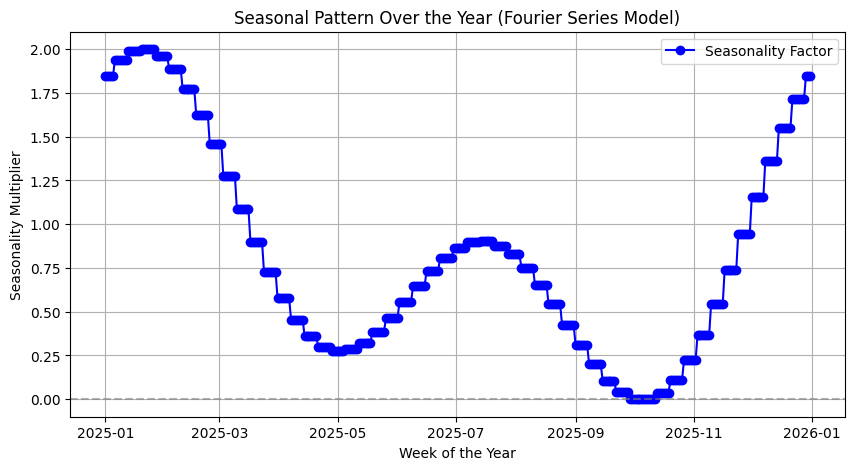

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["seasonal_multiplier"], marker="o", linestyle="-", color="b", label="Seasonality Factor")
plt.xlabel("Week of the Year")
plt.ylabel("Seasonality Multiplier")
plt.title("Seasonal Pattern Over the Year (Fourier Series Model)")
plt.axhline(0, color="gray", linestyle="--", alpha=0.6)  # Reference line
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
seasonal_multiplier_list

array(-2.78908253)

In [ ]:
s